In [1]:
from tifffile import imwrite, imread
from tkinter import filedialog as fd
import os
from os.path import dirname, basename, join, exists
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
from rich.progress import track

# matplotlib.use("Agg")
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

### functions

In [2]:
def cnt2box(cnt):
    # Note that the x and y of contours coordinates are swapped in cv2
    center_x = (cnt[:, 0][:, 1].max() + cnt[:, 0][:, 1].min()) / 2
    range_x = cnt[:, 0][:, 1].max() - cnt[:, 0][:, 1].min()
    center_y = (cnt[:, 0][:, 0].max() + cnt[:, 0][:, 0].min()) / 2
    range_y = cnt[:, 0][:, 0].max() - cnt[:, 0][:, 0].min()
    box_halfwidth = (np.max([range_x, range_y]) + box_padding * 2) / 2
    box_x_range = (
        math.floor(center_x - box_halfwidth),
        math.ceil(center_x + box_halfwidth),
    )
    box_y_range = (
        math.floor(center_y - box_halfwidth),
        math.ceil(center_y + box_halfwidth),
    )
    if box_x_range[0] < 0:
        box_x_min = 0
    else:
        box_x_min = box_x_range[0]

    if box_x_range[1] > xpixels_ONI:
        box_x_max = xpixels_ONI
    else:
        box_x_max = box_x_range[1]

    if box_y_range[0] < 0:
        box_y_min = 0
    else:
        box_y_min = box_y_range[0]

    if box_y_range[1] > ypixels_ONI:
        box_y_max = ypixels_ONI
    else:
        box_y_max = box_y_range[1]

    box_x_range_final = (box_x_min, box_x_max)
    box_y_range_final = (box_y_min, box_y_max)

    return box_x_range_final, box_y_range_final


def center_track_coordinates(df_in, box_x_range, box_y_range):
    selector = (
        (df_in.x > box_x_range[0])
        & (df_in.x < box_x_range[1])
        & (df_in.y > box_y_range[0])
        & (df_in.y < box_y_range[1])
    )
    df_in_box = df_in.loc[selector]
    # -0.5 to counter the fact that imshow grid starts from the edge not center
    track_x = df_in_box["x"].to_numpy(float) - box_x_range[0] - 0.5
    track_y = df_in_box["y"].to_numpy(float) - box_y_range[0] - 0.5
    df_in_box["x"] = track_x
    df_in_box["y"] = track_y
    return df_in_box


def cnt2mask(imgshape, contours):
    # create empty image
    mask = np.zeros(imgshape, dtype=np.uint8)
    # draw contour
    for cnt in contours:
        cv2.fillPoly(mask, [cnt], (255))
    return mask

In [3]:
# Optional functions
def single_condensate_stepsize_img(df_track, img_shape):
    ## Reconstruct step size iamge, unit: um
    lst_mid_x = []
    lst_mid_y = []
    lst_stepsize = []
    all_trackID = df_track["trackID"].unique()
    for trackID in all_trackID:
        df_current = df_track[df_track["trackID"] == trackID]
        xs = df_current["x"].to_numpy(float)
        ys = df_current["y"].to_numpy(float)
        mid_xs = (xs[1:] + xs[:-1]) / 2
        mid_ys = (ys[1:] + ys[:-1]) / 2
        steps = (
            np.sqrt((xs[1:] - xs[:-1]) ** 2 + (ys[1:] - ys[:-1]) ** 2) * um_per_pixel
        )
        lst_mid_x.extend(mid_xs)
        lst_mid_y.extend(mid_ys)
        lst_stepsize.extend(steps)

    df_all_steps = pd.DataFrame(
        {
            "mid_x": lst_mid_x,
            "mid_y": lst_mid_y,
            "stepsize": lst_stepsize,
        },
        dtype=float,
    )

    # put them in grid, calculate mean
    img_stepsize = np.zeros(img_shape)
    for x in range(img_stepsize.shape[0]):
        for y in range(img_stepsize.shape[1]):
            df_current = df_all_steps[
                df_all_steps["mid_x"].between(x, x + 1)
                & df_all_steps["mid_y"].between(y, y + 1)
            ]
            mean_stepsize = df_current["stepsize"].mean()
            img_stepsize[x, y] = mean_stepsize

    return img_stepsize


def smooth_stepsize_img(img_stepsize, sigma):
    img_stepsize_no_nan = np.nan_to_num(img_stepsize)
    img_stepsize_smoothed = gaussian_filter(img_stepsize_no_nan, sigma)
    return img_stepsize_smoothed


def plt_cnt_tracks_individual(
    img, cnt, df_track, vmin, vmax, box_x_range, box_y_range, cmap, fpath
):
    plt.figure()
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    x = cnt[:, 0][:, 0]
    x = x - box_y_range[0]
    y = cnt[:, 0][:, 1]
    y = y - box_x_range[0]
    plt.plot(x, y, "-", color="black", linewidth=2)
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color="black", linewidth=2)
    all_trackID = df_track["trackID"].unique()
    for trackID in all_trackID:
        plt.plot(
            df_track[df_track["trackID"] == trackID].y,
            df_track[df_track["trackID"] == trackID].x,
            ".-k",
            alpha=0.05,
        )
    plt.show()

### path and parameters

In [4]:
# Basic ONI parameters
um_per_pixel = 0.117
scaling_factor = 1
um_per_pixel_PAINT = um_per_pixel / scaling_factor
xpixels_ONI = 418
ypixels_ONI = 674
xedges = np.arange((xpixels_ONI + 1) * scaling_factor)
yedges = np.arange((ypixels_ONI + 1) * scaling_factor)

In [135]:
channel_postfix = "FUS"
home_folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/all_SPT_in_condensates/Reconstruction_40ms-miR21-FUS488-ALEX/20240926_processed-FUS_miR_ALEX"
fname_csv = "20230928-FOV-6-right-spots_reformatted.csv"
fname_recon_img = fname_csv.split("spots")[0] + "PAINT.tif"
box_padding = 5  # pixels padding arround each contour

### find optimal threashold for FOV

In [136]:
os.chdir(home_folder)
df_singlechannel = pd.read_csv(fname_csv)
img_PAINT_singlechannel = imread(fname_recon_img)

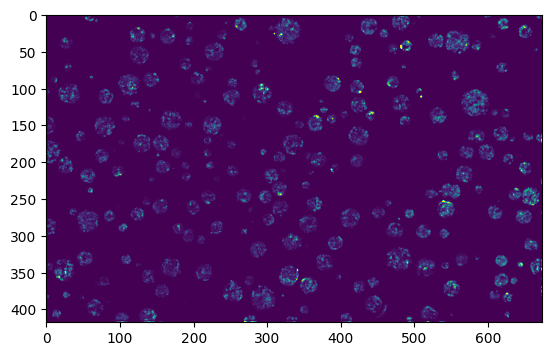

In [137]:
# img_denoise = gaussian_filter(img_PAINT_singlechannel, sigma=1)
plt.imshow(
    img_PAINT_singlechannel,
    # vmin=15,
    vmax=50,
)

Number of objects found: 54


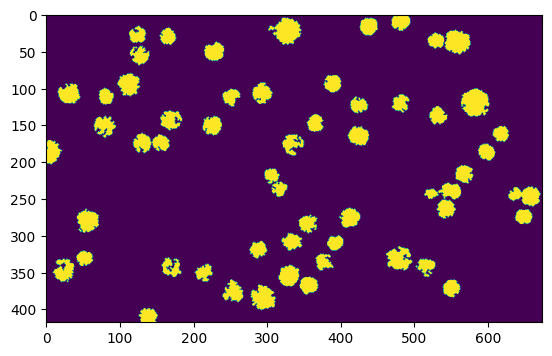

In [138]:
# These two are parameters you may want to tune
sum_loc_threshold = 3
condensate_area_threshold = 300 # 300 should be fixed since only large enough condensates should be quantified

# find contours coordinates in binary edge image. contours here is a list of np.arrays containing all coordinates of each individual edge/contour.
# edges = img_denoise > sum_loc_threshold
edges = img_PAINT_singlechannel > sum_loc_threshold
contours, _ = cv2.findContours(edges * 1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# Merge overlapping contours
mask = cnt2mask(img_PAINT_singlechannel.shape, contours)
contours_final, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

# filter out small condensates
contours_filtered = [
    cnt
    for cnt in contours_final
    if cv2.contourArea(cnt) > condensate_area_threshold
]

print("Number of objects found:", len(contours_filtered))
plt.imshow(cnt2mask(img_PAINT_singlechannel.shape, contours_filtered))

### create folder and store all individual condensates

In [139]:
folder_name_tosave = fname_csv.split("-spots")[0]
if not exists(folder_name_tosave):
    os.mkdir(folder_name_tosave)

In [140]:
condensateID = 0
for cnt in track(contours_filtered):
    ## determine a square box for individual condensate
    box_x_range, box_y_range = cnt2box(cnt)

    ## center both cnt and tracks coordinates to the center of the box
    cnt_centered = deepcopy(cnt)
    cnt_centered[:, 0][:, 0] = cnt_centered[:, 0][:, 0] - box_y_range[0]
    cnt_centered[:, 0][:, 1] = cnt_centered[:, 0][:, 1] - box_x_range[0]
    df_singlechannel_inbox = center_track_coordinates(
        df_singlechannel, box_x_range, box_y_range
    )

    ## crop img_PAINT by the box
    img_PAINT_singlechannel_inbox = img_PAINT_singlechannel[
        box_x_range[0] : box_x_range[1], box_y_range[0] : box_y_range[1]
    ]

    ## Calculate step size image
    # box_shape = (np.ptp(box_x_range), np.ptp(box_y_range))
    # img_stepsize_singlechannel = single_condensate_stepsize_img(
    #     df_singlechannel_inbox, box_shape
    # )
    # img_stepsize_singlechannel_smoothed = smooth_stepsize_img(
    #     img_stepsize_singlechannel, 1
    # )

    ## save csv within box, img_PAINT, img_stepsize, and a plot with img_PAINT+cnt+tracks
    fname_save_prefix = (
        fname_csv.split("-spot")[0]
        + "-condensateID-"
        + str(condensateID)
        + "-"
        + channel_postfix
    )
    df_singlechannel_inbox.to_csv(
        join(folder_name_tosave, fname_save_prefix + ".csv"), index=False
    )
    imwrite(
        join(folder_name_tosave, fname_save_prefix + "-PAINT.tif"),
        img_PAINT_singlechannel_inbox,
    )
    # imwrite(
    #     fname_save_prefix + "-stepsize.tif",
    #     img_stepsize_singlechannel_smoothed,
    # )
    pickle.dump(
        cnt_centered,
        open(join(folder_name_tosave, fname_save_prefix + "-cnt_centered.p"), "wb"),
    )
    # plt_cnt_tracks_individual(
    #     img_PAINT_singlechannel_inbox,
    #     cnt,
    #     df_singlechannel_inbox,
    #     0,
    #     20,
    #     box_x_range,
    #     box_y_range,
    #     "Blues",
    #     fname_save_prefix + "-PAINT_cnt_tracks.png",
    # )

    condensateID += 1

Output()